# Import the libraries

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from sklearn import preprocessing
import time
import pandas as pd
import gc
import multiprocessing
from multiprocessing import Process, Queue

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



# Definition of programmer's parameters (Controller's block)

In [2]:
#@markdown ##Synopses-based Training Optimization Configuration
# Percentage of the dataset that will be used for training
sample_size_low = 0.05 #@param {type:"number"}
sample_size_step = 0.1 #@param {type:"number"}
sample_size_high = 1 #@param {type:"number"}

# The ID of the method that will be employed during sampling
# 0: Simple reservoir sampling in our initial training dataset
# 1: Reservoir sampling in each class based on the number of samples (per class)
sampling_method_id = 1 #@param {type:"integer"}

#@markdown ##NN Architecture Configuration
total_num_of_layers = 5 #@param {type:"integer"}

set_of_layers = ['conv', 'pool', 'lstm', 'gru', 'rnn', 'dense']

# Number of epochs for the training process
# One Epoch is when an ENTIRE (training) dataset is passed forward and backward through the neural network only once.
# NOTE: An epoch is comprised of one or more batches.
num_of_epochs_low = 1 #@param {type:"slider", min:1, max:30, step:1}
num_of_epochs_step = 4 #@param {type:"integer"}
num_of_epochs_high = 20 #@param {type:"slider", min:1, max:31, step:1}

# The value for the learning rate for the training process (it is inserted to the Adam optimizer)
# During the optimization, the algorithm needs to take a series of tiny steps to descend the error mountain in order to minimize the error.
# The direction of the step is determined by the gradient, while the step size is determined by the learning rate.
lr_low = 1e-3 #@param {type:"number"}
lr_high = 1e-3 #@param {type:"number"}
lr_list = np.geomspace(lr_low, lr_high, num = int(np.log10(lr_high) - np.log10(lr_low)) + 1).tolist()

# The size of the batch for the training process
# Total number of training examples present in a single batch.
# or, number of samples processed before the model is updated.
size_of_batch_low = 10 #@param {type:"integer"}
size_of_batch_step = 16 #@param {type:"integer"}
size_of_batch_high = 10 #@param {type:"integer"}

#@markdown ##Tradeoff score Configuration
# Maximum training time above which we cancel the experiment (in seconds)
# It is used in the score (accuracy--speed tradeoff) formula
theta_parameter = 10 #@param {type:"integer"}

# Weight for the accuracy of the model. Max value: 0.99
# There is also the weight of training speed of the model (1 - lamda_acc)
# It is used in the score (accuracy--speed tradeoff) formula
lamda_acc = 0.5 #@param {type:"number"}

#@markdown ##Other Configuration(s)

# Height and width to which each video will be resized
IMAGE_HEIGHT = 64 #@param {type:"integer"}
IMAGE_WIDTH = 64 #@param {type:"integer"}

# Number of frames of a SINGLE video that will be fed to the model (as a single sequence)
SEQUENCE_LENGTH = 20 #@param {type:"integer"}

# Classes that will be used
CLASSES_LIST = ["Punch", "Skijet", "WalkingWithDog", "HorseRace", "Diving", "PushUps", "Kayaking", "PlayingPiano", "Rowing", "Skiing"]

CONV_NEURONS_CONST = 16 #@param {type:"integer"}
CONV_NEURONS_BOUND = 64 #@param {type:"integer"}
UNITS_CONST = 32 #@param {type:"integer"}
UNITS_BOUND = 32 #@param {type:"integer"}
DENSE_NEURONS_CONST = 128 #@param {type:"integer"}
DENSE_NEURONS_BOUND = 32 #@param {type:"integer"}


# Download & Visualize our Data

It takes a while...

In [3]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRa

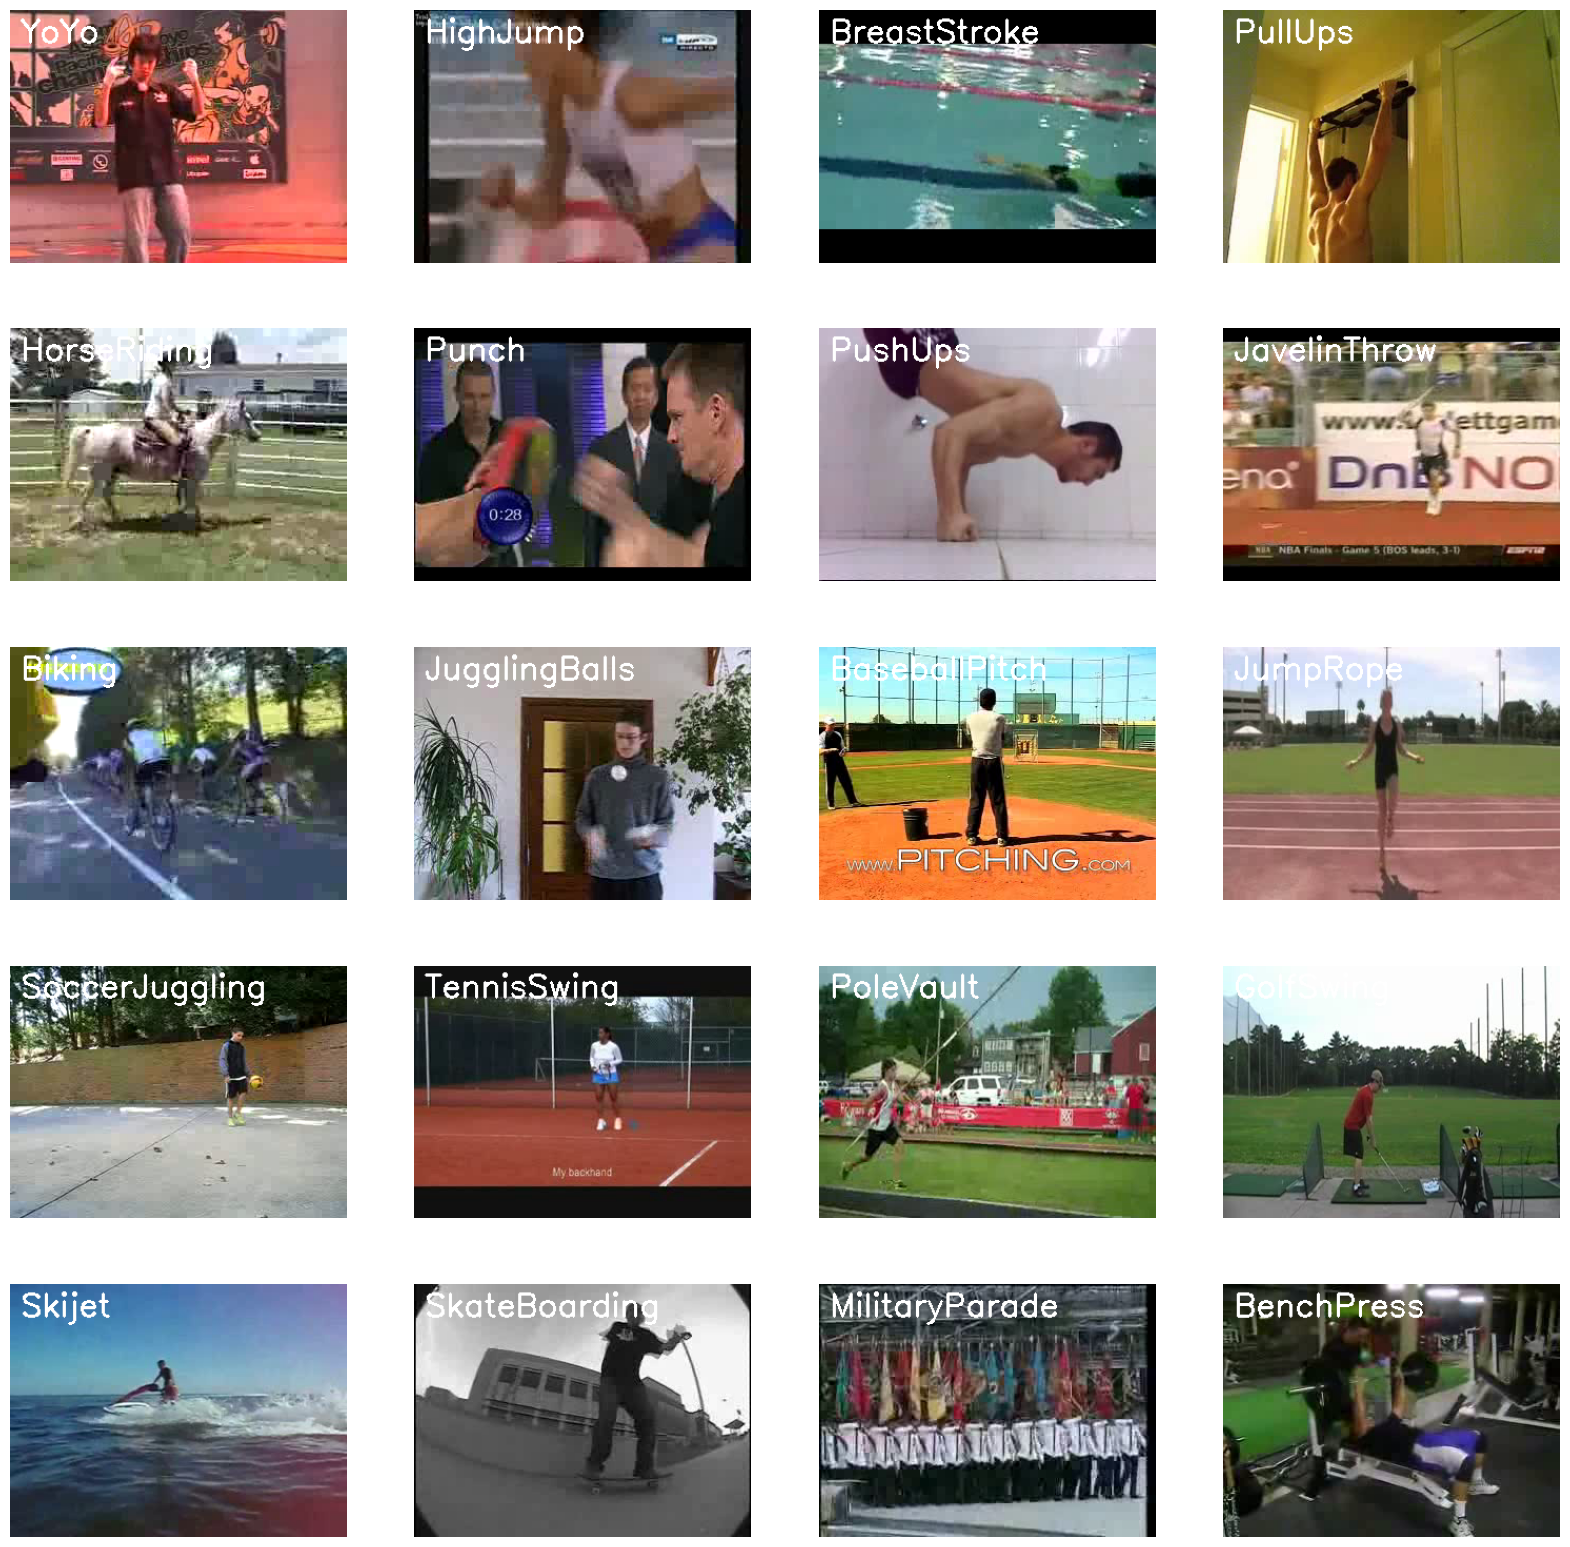

In [4]:
plt.figure(figsize = (20, 20))

# Get the names of all available classes
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random variables (between 0 - #num_of_classes)
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterate over random variables
for counter, random_index in enumerate(random_range, 1):
  # Retrieve the name of the corresponding class
  selected_class_Name = all_classes_names[random_index]

  # Retrieve the list of all videos that are contained in the selected class and select a single one randomly
  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  # Read the first frame from the selected video
  _, bgr_frame = video_reader.read()
  video_reader.release()

  # Convert frame from BGR to RGB
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the corresponding label
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  # Plot the frame
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# Pre-process Part

In [5]:
DATASET_DIR = "UCF50"

Function for extracting the required frames from a video after employing resizing and normalization procedures

In [6]:
def frames_extraction(video_path):
  # Store the video frames
  frames_list = []

  # Read the video
  video_reader = cv2.VideoCapture(video_path)

  # Get total number of frames (of this video)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the interval after which frames will be stored (the step)
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Iterate over video-frames
  for frame_counter in  range(SEQUENCE_LENGTH):
    # Adjust the pointer of current frame
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Read the corresponding frame
    success, frame = video_reader.read()

    if not success:
      break

    # Resize-normalize the frame and save it to the corresponding list
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

Function that creates the dataset that will be used

In [7]:
def create_dataset():
  # Lists that contain the extracted features, the labels and the paths of the videos
  features = []
  labels = []
  video_files_paths = []

  # Iterate through all (selected) classes
  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class: {class_name}')

    # Get the videos that are contained in each (selected) class
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # Convert lists to numpy arrays
  features = np.asarray(features)
  labels = np.asarray(labels)

  return features, labels, video_files_paths


In [8]:
# Create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Punch
Extracting Data of Class: Skijet
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: HorseRace
Extracting Data of Class: Diving
Extracting Data of Class: PushUps
Extracting Data of Class: Kayaking
Extracting Data of Class: PlayingPiano
Extracting Data of Class: Rowing
Extracting Data of Class: Skiing


# Split the Data into Train and Test sets

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, shuffle = True)

# Sampling Part

In [10]:
# A function that prints the occurence of each class in a list
def print_times_per_label(lst, labels_all):
  # Get unique labels in our training dataset
  unique_labels = np.unique(labels_all)
  for i in range(0, len(unique_labels)):
    print("Class", unique_labels[i], "has", lst.count(i), "samples in our dataset...")

In [11]:
# A function to randomly select k items from stream[0..n-1].
def reservoir_sampling(stream, n, k):
  i = 0     # index for elements in stream[]

  # reservoir[] is the output array.
  # Initialize it with first k elements from stream[]
  reservoir = [0] * k

  for i in range(k):
    reservoir[i] = stream[i]

  # Iterate from the (k+1)th element to Nth element
  while(i < n):
    # Pick a random index from 0 to i.
    j = random.randrange(i+1)

    # If the randomly picked
    # index is smaller than k,
    # then replace the element
    # present at the index
    # with new element from stream
    if(j < k):
      reservoir[j] = stream[i]
    i+=1

  return reservoir

In [12]:
# A function that finds the size of each reservoir for every class depending on its occurence in the initial dataset
# and returns the unique labels that exist in our dataset along with the corresponding percentage
def reservoir_size_per_class(init_labels):

  # Get unique labels and their counts (how many times they appear) in our training dataset
  unique_labels, counts = np.unique(init_labels, return_counts = True)

  # Transform to list
  unique_labels_lst = unique_labels.tolist()
  counts_lst = counts.tolist()

  perc_per_class = []
  for i in range(len(unique_labels_lst)):
    perc_per_class.append(counts_lst[i]/len(init_labels))

  # print(perc_per_class)

  return perc_per_class, unique_labels_lst

In [13]:
def sampling_method(sampling_method_id, features_train, labels_train, perc_train):
  print("Percentage of filtering in our training dataset was set:")
  print(perc_train)
  print("Pre-sampling training data:")
  print_times_per_label(labels_train.tolist(), np.unique(labels_train))
  if sampling_method_id == 0:
    # Simple reservoir sampling over the whole training dataset
    # Total size of the stream (or training dataset)
    n_train = len(features_train)

    # Number of samples that will be drawn
    k_train = int(n_train * perc_train)

    # Use the indexes of dataset in order to decide which samples will be drawn
    idx_tmp_train_list = list(range(0, n_train))

    # Find the indexes in order to construct the dataset that will be used during the training process
    idx_train = reservoir_sampling(idx_tmp_train_list, n_train, k_train)
  else:
    # Reservoir sampling in each class based on the number of samples (per class) that exist in the initial dataset
    # Find the size of each reservoir for every class depending on its occurence in the initial training dataset
    class_perc, unique_ids = reservoir_size_per_class(labels_train)

    # Stores the indexes (from all classes) in order to construct the dataset that will be used during the training process
    idx_train = []

    # Run for every single class the reservoir sampling seperately
    for i in range(0, len(unique_ids)):
      # Find the locations of each sample belonging to our class of interest
      tmp = np.where(labels_train == unique_ids[i])
      idx_of_class = tmp[0].tolist()

      # Run the reservoir sampling for the class of interest
      sampled_idx_of_class = reservoir_sampling(idx_of_class, len(idx_of_class), int(len(features_train) * perc_train * class_perc[i]))

      # Store the (sampled) samples from this class
      for j in range(0, len(sampled_idx_of_class)):
        idx_train.append(sampled_idx_of_class[j])

  # Store the corresponding images and labels from training dataset based on the sampled indexes
  train_images_lst = []
  for i in idx_train:
    train_images_lst.append(features_train[i])

  train_labels_lst = []
  for i in idx_train:
    train_labels_lst.append(labels_train[i])

  # Check the occurence of each class in the final training dataset
  print("====================================================")
  print("Post-sampling dataset:")
  print_times_per_label(train_labels_lst, labels_train)

  # Tranfsorm the lists that we stored our samples into arrays
  x_train = np.asarray(train_images_lst)
  y_train = np.asarray(train_labels_lst)

  # Verify that the desired filtering was performed in both datasets
  print("====================================================")
  print("Training dataset before sampling:")
  print(features_train.shape)
  print(labels_train.shape)
  print("Training dataset after sampling:")
  print(x_train.shape)
  print(y_train.shape)

  return x_train, y_train

# Create our model

In [14]:
def recreate_model(layers_lst, layer2add, CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND):

  # Initialize a sequential model
  model = tf.keras.models.Sequential()

  # Define the number of neurons for conv and dense layers and the number of units for lstm-gru-rnn
  conv_tmp2 = CONV_NEURONS_CONST
  units_tmp2 = UNITS_CONST
  dense_tmp2 = DENSE_NEURONS_CONST

  # Find the type of the next and the previous layer because you need different configurations
  for count, layer in enumerate(layers_lst):
    if count == 0 and len(layers_lst) > 1:
      previous_layer_tmp = 'no'
      next_layer_tmp = layers_lst[count + 1]
    elif count == 0:
      previous_layer_tmp = 'no'
      next_layer_tmp = 'no'
    elif count == len(layers_lst) - 1:
      next_layer_tmp = 'no'
      previous_layer_tmp = layers_lst[count - 1]
    else:
      previous_layer_tmp = layers_lst[count - 1]
      next_layer_tmp = layers_lst[count + 1]

    # Recreate the so-far-model
    # First layer conv
    if layer == 'conv' and count == 0:
      model.add(TimeDistributed(Conv2D(int(conv_tmp2), (3, 3), padding = 'same', activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
      conv_tmp2 = conv_tmp2 * 2
    # First layer lstm-gru-rnn (change the shape of the input) and next or 2-be-added layer lstm-gru-rnn (should add the 'return conf')
    elif ((layer == 'lstm' or layer == 'gru' or layer == 'rnn') and (((count == 0) and len(layers_lst) == 1 and (layer2add == 'lstm' or layer2add == 'gru' or layer2add == 'rnn')) or ((count == 0) and (next_layer_tmp == 'lstm' or next_layer_tmp == 'gru' or next_layer_tmp == 'rnn')))):
      if layer == 'lstm':
        model.add(tf.keras.layers.LSTM(int(units_tmp2), return_sequences = True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      elif layer == 'gru':
        model.add(tf.keras.layers.GRU(int(units_tmp2), return_sequences = True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      else:
        model.add(tf.keras.layers.SimpleRNN(int(units_tmp2), return_sequences = True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      units_tmp2 = units_tmp2 / 2
    # First layer lstm-gru-rnn (change the shape of the input)
    elif ((layer == 'lstm' or layer == 'gru' or layer == 'rnn') and count == 0):
      if layer == 'lstm':
        model.add(tf.keras.layers.LSTM(int(units_tmp2), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      elif layer == 'gru':
        model.add(tf.keras.layers.GRU(int(units_tmp2), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      else:
        model.add(tf.keras.layers.SimpleRNN(int(units_tmp2), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      units_tmp2 = units_tmp2 / 2
    # First layer densse (change the shape of the input)
    elif layer == 'dense' and count == 0:
      model.add(tf.keras.layers.Dense(int(dense_tmp2), activation='relu', input_shape=(SEQUENCE_LENGTH * IMAGE_HEIGHT * IMAGE_WIDTH * 3,)))
      dense_tmp2 = dense_tmp2 / 2
    # For the remaining layers
    else:
      if layer == 'conv':
        # Add a conv layer by doubling its neurons if they do not violate our user-defined bound
        if conv_tmp2 <= CONV_NEURONS_BOUND:
          model.add(TimeDistributed(Conv2D(int(conv_tmp2), (3, 3), padding = 'same', activation='relu')))
          conv_tmp2 = conv_tmp2 * 2
        else:
          model.add(TimeDistributed(Conv2D(int(CONV_NEURONS_BOUND), (3, 3), padding = 'same', activation='relu')))
          conv_tmp2 = CONV_NEURONS_BOUND
      elif layer == 'pool':
        # Add a pool layer
        model.add(TimeDistributed(MaxPooling2D((4, 4))))
      elif layer == 'lstm':
        # If the previous layer is conv or pool add a flatten layer first
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(TimeDistributed(BatchNormalization()))
          model.add(TimeDistributed(Flatten()))
        # Add a lstm layer by reducing (* 0.5) its units if they do not violate our user-defined bound
        if units_tmp2 >= UNITS_BOUND:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.LSTM(int(units_tmp2)))
          else:
            model.add(tf.keras.layers.LSTM(int(units_tmp2), return_sequences = True))
          units_tmp2 = units_tmp2 / 2
        else:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.LSTM(int(UNITS_BOUND)))
          else:
            model.add(tf.keras.layers.LSTM(int(UNITS_BOUND), return_sequences = True))
          units_tmp2 = UNITS_BOUND
      elif layer == 'gru':
        # If the previous layer is conv or pool add a flatten layer first
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(TimeDistributed(BatchNormalization()))
          model.add(TimeDistributed(Flatten()))
        # Add a gru layer by reducing (* 0.5) its units if they do not violate our user-defined bound
        if units_tmp2 >= UNITS_BOUND:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.GRU(int(units_tmp2)))
          else:
            model.add(tf.keras.layers.GRU(int(units_tmp2), return_sequences = True))
          units_tmp2 = units_tmp2 / 2
        else:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.GRU(int(UNITS_BOUND)))
          else:
            model.add(tf.keras.layers.GRU(int(UNITS_BOUND), return_sequences = True))
          units_tmp2 = UNITS_BOUND
      elif layer == 'rnn':
        # If the previous layer is conv or pool add a flatten layer first
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(TimeDistributed(BatchNormalization()))
          model.add(TimeDistributed(Flatten()))
        # Add a rnn layer by reducing (* 0.5) its units if they do not violate our user-defined bound
        if units_tmp2 >= UNITS_BOUND:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.SimpleRNN(int(units_tmp2)))
          else:
            model.add(tf.keras.layers.SimpleRNN(int(units_tmp2), return_sequences = True))
          units_tmp2 = units_tmp2 / 2
        else:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.SimpleRNN(int(UNITS_BOUND)))
          else:
            model.add(tf.keras.layers.SimpleRNN(int(UNITS_BOUND), return_sequences = True))
          units_tmp2 = UNITS_BOUND
      else:
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(Flatten())
        # Add a dense layer by reducing (* 0.5) its neurons if they do not violate our user-defined bound
        if dense_tmp2 >= DENSE_NEURONS_BOUND:
          model.add(tf.keras.layers.Dense(int(dense_tmp2), activation='relu'))
          dense_tmp2 = dense_tmp2 / 2
        else:
          model.add(tf.keras.layers.Dense(int(DENSE_NEURONS_BOUND), activation='relu'))
          dense_tmp2 = DENSE_NEURONS_BOUND

  return model, conv_tmp2, units_tmp2, dense_tmp2

In [15]:
def my_evaluate_first_phase(q, layer, x_train, y_train, features_test, labels_test, epochs, lr, size_of_batch):
  # Initialize a sequential network
  model = tf.keras.models.Sequential()

  # Define the number of neurons for conv and dense layers and the number of units for lstm-gru-rnn
  conv_tmp = CONV_NEURONS_CONST
  units_tmp = UNITS_CONST
  dense_tmp = DENSE_NEURONS_CONST

  # First layer since this method is called only on the first iteration, i.e., the one-layered-networks
  # If the first layer is conv then reshape the input and add a flatten layer
  if layer == 'conv':
    model.add(TimeDistributed(Conv2D(int(conv_tmp), (3, 3), padding = 'same', activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    conv_tmp = conv_tmp * 2
    model.add(Flatten())
    reshaped_x_train = x_train
    reshaped_x_test = features_test
  # If the first layer is lstm-gru-rnn then reshape the input
  elif layer == 'lstm' or layer == 'gru' or layer == 'rnn':
    num_samples, num_frames, height, width, channels = x_train.shape
    if layer == 'lstm':
      model.add(tf.keras.layers.LSTM(int(units_tmp), input_shape=(num_frames, height * width * channels)))
    elif layer == 'gru':
      model.add(tf.keras.layers.GRU(int(units_tmp), input_shape=(num_frames, height * width * channels)))
    else:
      model.add(tf.keras.layers.SimpleRNN(int(units_tmp), input_shape=(num_frames, height * width * channels)))
    units_tmp = units_tmp / 2
    reshaped_x_train = x_train.reshape(num_samples, num_frames, height * width * channels)
    num_samples, num_frames, height, width, channels = features_test.shape
    reshaped_x_test = features_test.reshape(num_samples, num_frames, height * width * channels)
  # If the first layer is dense then reshape the input
  elif layer == 'dense':
    num_samples, num_frames, height, width, channels = x_train.shape
    model.add(tf.keras.layers.Dense(int(dense_tmp), activation='relu', input_shape=(num_frames * height * width * channels,)))
    dense_tmp = dense_tmp / 2
    reshaped_x_train = x_train.reshape(num_samples, num_frames * height * width * channels)
    num_samples, num_frames, height, width, channels = features_test.shape
    reshaped_x_test = features_test.reshape(num_samples, num_frames * height * width * channels)

  # Add manually a dense layer in order to evaluate the network
  model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation='softmax'))

  model.compile(optimizer=Adam(lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model.summary()

  start = time.time()

  blackbox = model.fit(x = reshaped_x_train,
                      y = y_train,
                      epochs = epochs,
                      batch_size = size_of_batch
                      )
  stop = time.time()

  # Compute the training speed of this CNN architecture
  tr_time = stop - start

  # Compute the accuracy of our training model in the testing dataset
  test_loss, test_acc = model.evaluate(reshaped_x_test,  labels_test, verbose=2)

  # Compute the metric that captures the accuracy--speed tradeoff
  # tradeOff_metric = lamda_acc * test_acc - (1 - lamda_acc) * math.tanh(tr_time/theta_parameter - 1)

  # Linear formula
  # tradeOff_metric = lamda_acc * test_acc + (1 - lamda_acc) * (1 - min(1, tr_time/theta_parameter))

  # Multiplicative formula
  # tradeOff_metric = test_acc ** lamda_acc * (1 - min(1, tr_time/theta_parameter)) ** (1 - lamda_acc)

  # Harmonic mean
  # tradeOff_metric = (2 * test_acc * (1 - min(1, tr_time/theta_parameter))) / (test_acc + 1 - min(1, tr_time/theta_parameter) + 1e-5)

  # Sigmoid
  # tradeOff_metric = (1 / (1 + np.exp(-test_acc))) * (1 - 1 / (1 + np.exp(-min(1, tr_time/theta_parameter))))

  # Piecewise
  # tradeOff_metric = test_acc if tr_time <= theta_parameter else test_acc * max(0, 1 - 0.5 * (tr_time - theta_parameter))

  # F1 like
  # alpha = 2
  # tradeOff_metric = ((1 + alpha**2) * test_acc * min(1, tr_time/theta_parameter)) / (alpha ** 2 * test_acc + min(1, tr_time/theta_parameter))

  # Exp decay penalty
  # tradeOff_metric = test_acc * np.exp(-0.5 * min(1, tr_time/theta_parameter))

  # inverse additive penalty
  tradeOff_metric = test_acc / (1 + 0.5 * min(1, tr_time/theta_parameter))

  # min-based tradeoff
  # tradeOff_metric = min(test_acc, min(1, tr_time/theta_parameter))

  # product with complement
  # tradeOff_metric = test_acc * (1 - min(1, tr_time/theta_parameter))

  # square root compensation
  # tradeOff_metric = np.sqrt(test_acc) * np.sqrt(1 - min(1, tr_time/theta_parameter))

  # jacard style normalization
  # tradeOff_metric = test_acc * (1 - min(1, tr_time/theta_parameter)) / (test_acc + (1 - min(1, tr_time/theta_parameter)) - test_acc * (1 - min(1, tr_time/theta_parameter)))

  # log-sigmoid dominance
  # tradeOff_metric = 1 / (1 + np.exp(-0.5 * (test_acc - (1 - min(1, tr_time/theta_parameter)))))

  del model

  print("========================== EDW EINAI TO MULTI1111111111111111.......")
  print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
  print(f"Training time: ", tr_time)
  print(tradeOff_metric)

  q.put([test_acc, tr_time, tradeOff_metric])

In [16]:
def my_evaluate_rest_phase(q, x_train, y_train, features_test, labels_test, best_epochs, best_lr, best_batch, layer, best_layers, CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND):

  # Recreate the network that consist of the best layers that we found in each of the previous steps/iterations
  model, conv_tmp, units_tmp, dense_tmp = recreate_model(best_layers, layer, CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND)

  # If the to-be-added-layer is conv
  if layer == 'conv':
    # Add a conv layer by doubling its neurons if they do not violate our user-defined bound
    if conv_tmp <= CONV_NEURONS_BOUND:
      model.add(TimeDistributed(Conv2D(int(conv_tmp), (3, 3), padding = 'same', activation = 'relu')))
      conv_tmp = conv_tmp * 2
    else:
      model.add(TimeDistributed(Conv2D(int(CONV_NEURONS_BOUND), (3, 3), padding = 'same', activation='relu')))
  # If the to-be-added-layer is pool
  elif layer == 'pool':
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
  # If the to-be-added-layer is lstm
  elif layer == 'lstm':
    # If the previous layer is either conv or pool then add first a flatten layer
    if best_layers[-1] == 'conv' or best_layers[-1] == 'pool':
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(Flatten()))
    # Add a lstm layer by reducing (* 0.5) its units if they do not violate our user-defined bound
    if units_tmp >= UNITS_BOUND:
      model.add(tf.keras.layers.LSTM(int(units_tmp)))
      units_tmp = units_tmp / 2
    else:
      model.add(tf.keras.layers.LSTM(int(UNITS_BOUND)))
      units_tmp = UNITS_BOUND
  # If the to-be-added-layer is gru
  elif layer == 'gru':
    # If the previous layer is either conv or pool then add first a flatten layer
    if best_layers[-1] == 'conv' or best_layers[-1] == 'pool':
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(Flatten()))
    # Add a gru layer by reducing (* 0.5) its units if they do not violate our user-defined bound
    if units_tmp >= UNITS_BOUND:
      model.add(tf.keras.layers.GRU(int(units_tmp)))
      units_tmp = units_tmp / 2
    else:
      model.add(tf.keras.layers.GRU(int(UNITS_BOUND)))
      units_tmp = UNITS_BOUND
  # If the to-be-added-layer is rnn
  elif layer == 'rnn':
    # If the previous layer is either conv or pool then add first a flatten layer
    if best_layers[-1] == 'conv' or best_layers[-1] == 'pool':
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(Flatten()))
    # Add a rnn layer by reducing (* 0.5) its units if they do not violate our user-defined bound
    if units_tmp >= UNITS_BOUND:
      model.add(tf.keras.layers.SimpleRNN(int(units_tmp)))
      units_tmp = units_tmp / 2
    else:
      model.add(tf.keras.layers.SimpleRNN(int(UNITS_BOUND)))
      units_tmp = UNITS_BOUND
  # If the to-be-added-layer is dense
  else:
    # If the next to-be-added-layer is dense and the previous layer is either conv or pool then add manually a flatten layer
    if best_layers[-1] == 'conv' or best_layers[-1] == 'pool':
      model.add(Flatten())
    # Add a dense layer by reducing (* 0.5) its neurons if they do not violate our user-defined bound
    if dense_tmp >= DENSE_NEURONS_BOUND:
      model.add(tf.keras.layers.Dense(int(dense_tmp), activation='relu'))
      dense_tmp = dense_tmp / 2
    else:
      model.add(tf.keras.layers.Dense(int(DENSE_NEURONS_BOUND), activation='relu'))
      dense_tmp = DENSE_NEURONS_BOUND

  # If the just-added-layer was conv or pool then add manually a flatten layer
  if layer == 'conv' or layer == 'pool':
    model.add(Flatten())

  # Softmax is an activation function that is used mainly for classification tasks
  # It normalizes the input vector into a probability distribution  that is proportional to the exponential of the input numbers.
  model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation = "softmax"))

  model.compile(optimizer=Adam(best_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model.summary()

  # Here we reshape the input of the network based on the type of the first layer of the network
  # If the first layer is conv
  if best_layers[0] == 'conv':
    reshaped_x_train = x_train
    reshaped_x_test = features_test
  # If the first layer is lstm-gru-rnn
  elif best_layers[0] == 'lstm' or best_layers[0] == 'gru' or best_layers[0] == 'rnn':
    num_samples, num_frames, height, width, channels = x_train.shape
    reshaped_x_train = x_train.reshape(num_samples, num_frames, height * width * channels)
    num_samples, num_frames, height, width, channels = features_test.shape
    reshaped_x_test = features_test.reshape(num_samples, num_frames, height * width * channels)
  # If the first layer is dense
  else:
    num_samples, num_frames, height, width, channels = x_train.shape
    reshaped_x_train = x_train.reshape(num_samples, num_frames * height * width * channels)
    num_samples, num_frames, height, width, channels = features_test.shape
    reshaped_x_test = features_test.reshape(num_samples, num_frames * height * width * channels)

  start = time.time()

  blackbox = model.fit(x=reshaped_x_train,
                      y=y_train,
                      epochs=best_epochs,
                      batch_size=best_batch
                      )
  stop = time.time()

  # Compute the training speed of this CNN architecture
  tr_time = stop - start

  # Compute the accuracy of our training model in the testing dataset
  test_loss, test_acc = model.evaluate(reshaped_x_test,  labels_test, verbose=2)

  # Compute the metric that captures the accuracy--speed tradeoff
  # tradeOff_metric = lamda_acc * test_acc - (1 - lamda_acc) * math.tanh(tr_time/theta_parameter - 1)

  # Linear formula
  # tradeOff_metric = lamda_acc * test_acc + (1 - lamda_acc) * (1 - min(1, tr_time/theta_parameter))

  # Multiplicative formula
  # tradeOff_metric = test_acc ** lamda_acc * (1 - min(1, tr_time/theta_parameter)) ** (1 - lamda_acc)

  # Harmonic mean
  # tradeOff_metric = (2 * test_acc * (1 - min(1, tr_time/theta_parameter))) / (test_acc + 1 - min(1, tr_time/theta_parameter) + 1e-5)

  # Sigmoid
  # tradeOff_metric = (1 / (1 + np.exp(-test_acc))) * (1 - 1 / (1 + np.exp(-min(1, tr_time/theta_parameter))))

  # Piecewise
  # tradeOff_metric = test_acc if tr_time <= theta_parameter else test_acc * max(0, 1 - 0.5 * (tr_time - theta_parameter))

  # F1 like
  # alpha = 2
  # tradeOff_metric = ((1 + alpha**2) * test_acc * min(1, tr_time/theta_parameter)) / (alpha ** 2 * test_acc + min(1, tr_time/theta_parameter))

  # Exp decay penalty
  # tradeOff_metric = test_acc * np.exp(-0.5 * min(1, tr_time/theta_parameter))

  # inverse additive penalty
  tradeOff_metric = test_acc / (1 + 0.5 * min(1, tr_time/theta_parameter))

  # min-based tradeoff
  # tradeOff_metric = min(test_acc, min(1, tr_time/theta_parameter))

  # product with complement
  # tradeOff_metric = test_acc * (1 - min(1, tr_time/theta_parameter))

  # square root compensation
  # tradeOff_metric = np.sqrt(test_acc) * np.sqrt(1 - min(1, tr_time/theta_parameter))

  # jacard style normalization
  # tradeOff_metric = test_acc * (1 - min(1, tr_time/theta_parameter)) / (test_acc + (1 - min(1, tr_time/theta_parameter)) - test_acc * (1 - min(1, tr_time/theta_parameter)))

  # log-sigmoid dominance
  # tradeOff_metric = 1 / (1 + np.exp(-0.5 * (test_acc - (1 - min(1, tr_time/theta_parameter)))))

  del model

  print("========================== EDW EINAI TO MULTI2222222222.......")
  print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
  print(f"Training time: ", tr_time)
  print(tradeOff_metric)

  q.put([test_acc, tr_time, tradeOff_metric])



In [17]:
start_program = time.time()

# Get the shape of the input dataset
dataset_shape = features_train.shape

# Store the best type of layer of each step
best_layers = []

# Store the corresponding score. So the first position represents the score of the CNN that contains only the layer in the
# first position of best_layers list, the second the score of the CNN that contains the layers in the
# first and second position, etc.
best_scores = []
best_accuracies = []
best_times = []

# The best number of epochs, sample rate, learning rate and batch size
# This two quantities are computed during the first step/iteration, we keep the best ones and proceed to the
# next iterations with this numbers fixed
best_epochs = -1
best_sample_size = -1
best_lr = -1
best_batch = -1

# Loop for the number of layers that user indicated
for step in range(1, total_num_of_layers + 1):
  # Store for each step/iteration the so far best score
  best_found = -1
  best_acc = -1
  best_t = 100000000000

  # Store the type of layer that achieves the highest score for this step/iteration
  layer_2_add = ''

  # If this is the first step/iteration
  if step == 1:

    # The first layer in this set of datasets has to be a convolutional one!
    # So our "search space" all combinations of epochs and sampling rates based on user's input
    for sample_size in np.arange(sample_size_low, sample_size_high + 0.01, sample_size_step):
      for epochs in range(num_of_epochs_low, num_of_epochs_high + 1, num_of_epochs_step):
        for lr in lr_list:
          for size_of_batch in range(size_of_batch_low, size_of_batch_high + 1, size_of_batch_step):
            for layer in set_of_layers:

              # The first layer can't be pooling so skip this iteration
              if layer != 'conv':
                continue

              # Perform the sampling
              x_train, y_train = sampling_method(sampling_method_id, features_train, labels_train, sample_size)

              q = Queue()
              process_eval = multiprocessing.Process(target=my_evaluate_first_phase, args=(q, layer, x_train, y_train, features_test, labels_test, epochs, lr, size_of_batch))
              process_eval.start()
              test_acc, tr_time, tradeOff_metric = q.get()
              process_eval.join()

              # Print the results.
              print()
              print("========================== EDW EINAI TO CORE.......")
              print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
              print(f"Training time: ", tr_time)
              print(tradeOff_metric)
              print()

              # Delete the dfs.
              del x_train
              del y_train

              # Clear the Keras session, otherwise it will keep adding new
              # models to the same TensorFlow graph each time we create
              # a model with a different set of hyper-parameters.
              K.clear_session()
              tf.compat.v1.reset_default_graph()

              # Check if this was the best score for this iteration
              if tradeOff_metric > best_found:
                best_found = tradeOff_metric
                best_acc = test_acc
                best_t = tr_time
                layer_2_add = layer
                best_epochs = epochs
                best_sample_size = sample_size
                best_lr = lr
                best_batch = size_of_batch

  # If this is not the first step/iteration
  else:
    # For all the available types of layers
    for layer in set_of_layers:

      # After a dense laye you can only add a dense layer
      # So, don't examine the other types of layers
      if best_layers[-1] == 'dense' and layer != 'dense':
        continue

      # If the last added layer is lstm-gru-rnn you cannot add as next layer both conv and pool layers so skip these iterations
      if ((best_layers[-1] == 'lstm' or best_layers[-1] == 'gru' or best_layers[-1] == 'rnn') and (layer == 'conv' or layer == 'pool')):
        continue

      # Perform the sampling
      x_train, y_train = sampling_method(sampling_method_id, features_train, labels_train, best_sample_size)

      q = Queue()
      process_eval = multiprocessing.Process(target=my_evaluate_rest_phase, args=(q, x_train, y_train, features_test, labels_test, best_epochs, best_lr, best_batch, layer, best_layers, CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND))
      process_eval.start()
      test_acc, tr_time, tradeOff_metric = q.get()
      process_eval.join()

      # Print the results.
      print()
      print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
      print(f"Training time: ", tr_time)
      print(tradeOff_metric)
      print()

      # Delete the Keras model with these hyper-parameters from memory.
      K.clear_session()
      gc.collect()
      del x_train
      del y_train

      # Clear the Keras session, otherwise it will keep adding new
      # models to the same TensorFlow graph each time we create
      # a model with a different set of hyper-parameters.
      # K.clear_session()
      tf.compat.v1.reset_default_graph()

      # Check if this was the best score for this iteration
      if tradeOff_metric > best_found:
        best_found = tradeOff_metric
        best_acc = test_acc
        best_t = tr_time
        layer_2_add = layer

  # Add the best layer for this step/iteration and its corresponding score to our lists
  best_layers.append(layer_2_add)
  best_scores.append(best_found)
  best_accuracies.append(best_acc)
  best_times.append(best_t)


Percentage of filtering in our training dataset was set:
0.05
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0 has 5 samples in our dataset...
Class 1 has 3 samples in our dataset...
Class 2 has 4 samples in our dataset...
Class 3 has 5 samples in our dataset...
Class 4 has 5 samples in our dataset...
Class 5 has 3 samples in our dataset...
Class 6 has 5 samples in our dataset...
Class 7 has 4 samples in our dataset...
Class 8 has 5 samples in our dataset...
Class 9 has 5 samples in our dataset...
Training dataset before sampling:
(984, 20, 64, 64, 3)
(984,)
Training 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 873ms/step - accuracy: 0.1871 - loss: 134.8219
11/11 - 2s - 195ms/step - accuracy: 0.1951 - loss: 108.6462
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 19.51%
Training time:  10.115170240402222
0.13008129596710205

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 19.51%
Training time:  10.115170240402222
0.13008129596710205

Percentage of filtering in our training dataset was set:
0.05
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0 has 5 samp

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 882ms/step - accuracy: 0.1212 - loss: 86.6616
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2236 - loss: 56.0529
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4938 - loss: 24.7882
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5351 - loss: 14.9518
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7999 - loss: 4.8615
11/11 - 2s - 195ms/step - accuracy: 0.2043 - loss: 25.6337
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 20.43%
Training time:  9.58729863166809
0.13807836540640722

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 20.43%
Training time:  9.58729863166809
0.13807836540640722

Percentage of filtering in our training dataset was set:
0.05
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 h

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 884ms/step - accuracy: 0.1510 - loss: 69.6079
Epoch 2/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2293 - loss: 94.5165
Epoch 3/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3136 - loss: 57.2428
Epoch 4/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5049 - loss: 20.4635
Epoch 5/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6509 - loss: 5.4648
Epoch 6/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7207 - loss: 3.0309
Epoch 7/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0392
Epoch 8/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9883 - loss: 0.0725
Epoch 9/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9744 - loss: 0.0607    
11/11 - 2s - 198ms/step - accuracy: 0.2591 - loss: 5.1059
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 25.91%
Training time:  9.900798320770264
0.17333740053406568

========================== EDW EINAI TO

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 901ms/step - accuracy: 0.0366 - loss: 91.3786
Epoch 2/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2131 - loss: 101.6736
Epoch 3/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3234 - loss: 82.3350
Epoch 4/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5708 - loss: 17.4255
Epoch 5/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6662 - loss: 3.4730
Epoch 6/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8484 - loss: 2.3597
Epoch 7/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9203 - loss: 0.2642
Epoch 8/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 9/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0049    
Epoch 10/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0022    
Epoch 11/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.1458e-04
Epoch 12/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 892ms/step - accuracy: 0.1254 - loss: 98.2029
Epoch 2/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2270 - loss: 103.0811
Epoch 3/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3634 - loss: 49.4355
Epoch 4/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5255 - loss: 9.4326 
Epoch 5/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7902 - loss: 7.4922 
Epoch 6/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9744 - loss: 0.0631
Epoch 7/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9744 - loss: 0.0546    
Epoch 8/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9744 - loss: 0.4772    
Epoch 9/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9577 - loss: 0.1287
Epoch 10/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.7207e-07
Epoch 11/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.5373e-07
Epoch 12/17
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - lo

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.1230 - loss: 139.1397
11/11 - 2s - 197ms/step - accuracy: 0.2622 - loss: 49.0424
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 26.22%
Training time:  9.589190006256104
0.17722358081827075

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 26.22%
Training time:  9.589190006256104
0.17722358081827075

Percentage of filtering in our training dataset was set:
0.15000000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.1467 - loss: 70.8540
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4663 - loss: 18.4346
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8198 - loss: 1.4111
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9632 - loss: 0.0810
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9918 - loss: 0.0379
11/11 - 2s - 197ms/step - accuracy: 0.5061 - loss: 2.6856
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 50.61%
Training time:  10.043899297714233
0.33739837010701496

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 50.61%
Training time:  10.043899297714233
0.33739837010701496

Percentage of filtering in our training dataset was set:
0.15000000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in ou

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.1121 - loss: 85.1716
Epoch 2/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3660 - loss: 18.1799
Epoch 3/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7198 - loss: 1.1220
Epoch 4/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9621 - loss: 0.1835
Epoch 5/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9788 - loss: 0.0605
Epoch 6/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0181
Epoch 7/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 8/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 9/9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011    
11/11 - 2s - 197ms/step - accuracy: 0.4482 - loss: 2.0076
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 44.82%
Training time:  10.598835945129395
0.29878048102060956

========================== EDW

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.0649 - loss: 108.9306
Epoch 2/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3608 - loss: 23.1385
Epoch 3/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7087 - loss: 6.1967
Epoch 4/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8245 - loss: 0.9051
Epoch 5/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9732 - loss: 0.1213
Epoch 6/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9882 - loss: 0.0395
Epoch 7/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 8/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 9/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 10/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.3745e-04
Epoch 11/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6410e-04
Epoch 12/13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.1873 - loss: 149.4991
Epoch 2/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3228 - loss: 56.1474
Epoch 3/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5912 - loss: 4.8819
Epoch 4/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7432 - loss: 0.9153
Epoch 5/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9144 - loss: 0.1562
Epoch 6/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0384
Epoch 7/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0124
Epoch 8/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0063
Epoch 9/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 10/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 11/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0057
Epoch 12/17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.1439 - loss: 74.7308
11/11 - 2s - 197ms/step - accuracy: 0.1707 - loss: 26.5419
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 17.07%
Training time:  9.545988082885742
0.11557014639581265

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 17.07%
Training time:  9.545988082885742
0.11557014639581265

Percentage of filtering in our training dataset was set:
0.25000000000000006
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.1281 - loss: 88.3085
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4262 - loss: 8.7528
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8526 - loss: 0.5299
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9619 - loss: 0.1880
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0314
11/11 - 2s - 198ms/step - accuracy: 0.5732 - loss: 2.1870
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 57.32%
Training time:  10.324368953704834
0.38211381435394287

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 57.32%
Training time:  10.324368953704834
0.38211381435394287

Percentage of filtering in our training dataset was set:
0.25000000000000006
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.1141 - loss: 134.3113
Epoch 2/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4585 - loss: 14.6510
Epoch 3/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9106 - loss: 0.4906
Epoch 4/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9747 - loss: 0.0968
Epoch 5/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9774 - loss: 0.0391
Epoch 6/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 7/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 8/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5334e-04
Epoch 9/9
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9805e-04
11/11 - 2s - 200ms/step - accuracy: 0.5762 - loss: 2.0508
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 57.62%
Training time:  11.14907956123352
0.3841463327407837

========================== 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.1338 - loss: 72.1067
Epoch 2/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6823 - loss: 1.2939
Epoch 3/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9275 - loss: 0.3809
Epoch 4/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9867 - loss: 0.1266
Epoch 5/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0177
Epoch 6/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0088
Epoch 7/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0030
Epoch 8/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 9/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 10/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2586e-04
Epoch 11/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1224e-04
Epoch 12/13
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - lo

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.1989 - loss: 42.3180
Epoch 2/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5544 - loss: 3.1122
Epoch 3/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8614 - loss: 0.5105
Epoch 4/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9886 - loss: 0.1067
Epoch 5/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0550
Epoch 6/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0248
Epoch 7/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0123
Epoch 8/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0062
Epoch 9/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0038
Epoch 10/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 11/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 12/17
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.00

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.1417 - loss: 78.9868
11/11 - 2s - 196ms/step - accuracy: 0.3445 - loss: 6.1278
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 34.45%
Training time:  9.720232248306274
0.2318368117158295

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 34.45%
Training time:  9.720232248306274
0.2318368117158295

Percentage of filtering in our training dataset was set:
0.35000000000000003
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0 h

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.0996 - loss: 162.3275
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4185 - loss: 8.0746
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8307 - loss: 0.7278
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9798 - loss: 0.1761
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.0786
11/11 - 2s - 195ms/step - accuracy: 0.5915 - loss: 1.7996
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 59.15%
Training time:  10.921884298324585
0.3943089246749878

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 59.15%
Training time:  10.921884298324585
0.3943089246749878

Percentage of filtering in our training dataset was set:
0.35000000000000003
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.1864 - loss: 79.0089
Epoch 2/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5525 - loss: 6.6412
Epoch 3/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8707 - loss: 0.5747
Epoch 4/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9914 - loss: 0.0439
Epoch 5/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0072
Epoch 6/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 7/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3467e-04
Epoch 8/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8459e-04
Epoch 9/9
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4999e-04
11/11 - 2s - 195ms/step - accuracy: 0.6067 - loss: 2.0340
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 60.67%
Training time:  11.888811826705933
0.40447155634562176

=======================

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.1354 - loss: 83.5944
Epoch 2/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6347 - loss: 2.0504
Epoch 3/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9576 - loss: 0.2239
Epoch 4/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9974 - loss: 0.0385
Epoch 5/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0182
Epoch 6/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 7/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 8/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 9/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 10/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 11/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2612e-04
Epoch 12/13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.1682 - loss: 95.0663
Epoch 2/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5827 - loss: 3.8078
Epoch 3/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8663 - loss: 0.5359
Epoch 4/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9529 - loss: 0.2211
Epoch 5/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9957 - loss: 0.0559
Epoch 6/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0134
Epoch 7/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0052
Epoch 8/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 9/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8287e-04
Epoch 10/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4705e-04
Epoch 11/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9245e-04
Epoch 12/17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.2054 - loss: 34.6254
11/11 - 2s - 197ms/step - accuracy: 0.4421 - loss: 1.7252
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 44.21%
Training time:  9.955458879470825
0.2951536600718575

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 44.21%
Training time:  9.955458879470825
0.2951536600718575

Percentage of filtering in our training dataset was set:
0.45000000000000007
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0 ha

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.1617 - loss: 162.1530
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6554 - loss: 1.3537
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8786 - loss: 0.4486
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9687 - loss: 0.1719
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9930 - loss: 0.0506
11/11 - 2s - 197ms/step - accuracy: 0.5976 - loss: 1.2673
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 59.76%
Training time:  11.431604385375977
0.3983740011850993

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 59.76%
Training time:  11.431604385375977
0.3983740011850993

Percentage of filtering in our training dataset was set:
0.45000000000000007
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our d

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.1881 - loss: 74.7324
Epoch 2/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6813 - loss: 1.9783
Epoch 3/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9913 - loss: 0.0910
Epoch 4/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9931 - loss: 0.0380
Epoch 5/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0075
Epoch 6/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0059
Epoch 7/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 8/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 9/9
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012
11/11 - 2s - 195ms/step - accuracy: 0.6616 - loss: 1.6465
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 66.16%
Training time:  12.636332988739014
0.44105692704518634

========================== EDW EINAI

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.1551 - loss: 52.5218
Epoch 2/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6819 - loss: 1.7587
Epoch 3/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9662 - loss: 0.1776
Epoch 4/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0179
Epoch 5/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0109
Epoch 6/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0043
Epoch 7/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 8/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 9/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 10/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 11/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5669e-04
Epoch 12/13
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.2045 - loss: 83.0072
Epoch 2/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7784 - loss: 0.8422
Epoch 3/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9777 - loss: 0.2036
Epoch 4/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9914 - loss: 0.0750
Epoch 5/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0125
Epoch 6/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 7/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4390e-04
Epoch 8/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 9/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6274e-04
Epoch 10/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2827e-04
Epoch 11/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2674e-04
Epoch 12/17
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.00

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1899 - loss: 74.7291
11/11 - 2s - 201ms/step - accuracy: 0.4787 - loss: 2.8115
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 47.87%
Training time:  10.512203216552734
0.31910568475723267

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 47.87%
Training time:  10.512203216552734
0.31910568475723267

Percentage of filtering in our training dataset was set:
0.5500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2420 - loss: 44.7376
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7897 - loss: 0.6552
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9579 - loss: 0.1445
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9926 - loss: 0.0427
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0249
11/11 - 2s - 200ms/step - accuracy: 0.6616 - loss: 1.1872
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 66.16%
Training time:  12.218483686447144
0.44105692704518634

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 66.16%
Training time:  12.218483686447144
0.44105692704518634

Percentage of filtering in our training dataset was set:
0.5500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our d

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1857 - loss: 70.8953
Epoch 2/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7947 - loss: 0.8178
Epoch 3/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9608 - loss: 0.1800
Epoch 4/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9805 - loss: 0.0756
Epoch 5/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0299
Epoch 6/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0045
Epoch 7/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 8/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6557e-04
Epoch 9/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5770e-04
11/11 - 2s - 199ms/step - accuracy: 0.6707 - loss: 1.1401
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 67.07%
Training time:  13.966098308563232
0.4471544822057088

========================== ED

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2242 - loss: 83.7839
Epoch 2/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7645 - loss: 0.9565
Epoch 3/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9655 - loss: 0.1368
Epoch 4/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0386
Epoch 5/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0078
Epoch 6/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 7/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 8/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4615e-04
Epoch 9/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1279e-04
Epoch 10/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6582e-04
Epoch 11/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6534e-04
Epoch 12/13
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.00

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1995 - loss: 70.9881
Epoch 2/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7332 - loss: 0.7905
Epoch 3/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9829 - loss: 0.1214
Epoch 4/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0272
Epoch 5/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0115
Epoch 6/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0039
Epoch 7/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1343e-04
Epoch 8/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9974 - loss: 0.0092
Epoch 9/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0104
Epoch 10/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 11/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 12/17
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.2605 - loss: 57.5875
11/11 - 2s - 201ms/step - accuracy: 0.5122 - loss: 1.6355
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 51.22%
Training time:  10.641784191131592
0.3414634068806966

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 51.22%
Training time:  10.641784191131592
0.3414634068806966

Percentage of filtering in our training dataset was set:
0.6500000000000001
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0 h

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.2362 - loss: 30.0303
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8850 - loss: 0.4087
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9773 - loss: 0.1067
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9839 - loss: 0.0725
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0247
11/11 - 2s - 193ms/step - accuracy: 0.7165 - loss: 0.8940
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 71.65%
Training time:  12.392479658126831
0.4776422580083211

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 71.65%
Training time:  12.392479658126831
0.4776422580083211

Percentage of filtering in our training dataset was set:
0.6500000000000001
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dat

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.2181 - loss: 42.9382
Epoch 2/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8581 - loss: 0.5088
Epoch 3/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9699 - loss: 0.1390
Epoch 4/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9971 - loss: 0.0369
Epoch 5/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 6/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 7/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 8/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7318e-04
Epoch 9/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1059e-04
11/11 - 2s - 196ms/step - accuracy: 0.6494 - loss: 1.6032
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 64.94%
Training time:  14.662903547286987
0.43292681376139325

========================== 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.2464 - loss: 66.4956
Epoch 2/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8011 - loss: 0.8428
Epoch 3/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9763 - loss: 0.1438
Epoch 4/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9934 - loss: 0.0384
Epoch 5/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9977 - loss: 0.0172
Epoch 6/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 7/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.6858e-04
Epoch 8/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.6029e-04
Epoch 9/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6471e-04
Epoch 10/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9526e-04
Epoch 11/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2739e-04
Epoch 12/13
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy:

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2543 - loss: 57.8633
Epoch 2/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8380 - loss: 0.5260
Epoch 3/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9863 - loss: 0.0762
Epoch 4/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9827 - loss: 0.0857
Epoch 5/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0124
Epoch 6/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0043
Epoch 7/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 8/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 9/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 10/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.2405e-04
Epoch 11/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4051e-04
Epoch 12/17
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - los

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2269 - loss: 37.1361
11/11 - 2s - 195ms/step - accuracy: 0.5701 - loss: 1.3202
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 57.01%
Training time:  10.906071424484253
0.38008129596710205

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 57.01%
Training time:  10.906071424484253
0.38008129596710205

Percentage of filtering in our training dataset was set:
0.7500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2683 - loss: 21.0263
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8534 - loss: 0.6314
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9640 - loss: 0.1532
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9969 - loss: 0.0188
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0037
11/11 - 2s - 194ms/step - accuracy: 0.6982 - loss: 1.0139
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 69.82%
Training time:  13.058557987213135
0.4654471476872762

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 69.82%
Training time:  13.058557987213135
0.4654471476872762

Percentage of filtering in our training dataset was set:
0.7500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our da

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.2618 - loss: 14.3110
Epoch 2/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8754 - loss: 0.5202
Epoch 3/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9677 - loss: 0.1726
Epoch 4/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9947 - loss: 0.0480
Epoch 5/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0106
Epoch 6/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0071
Epoch 7/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 8/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.0662e-04
Epoch 9/9
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.1813e-04
11/11 - 2s - 199ms/step - accuracy: 0.7348 - loss: 0.8873
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 73.48%
Training time:  15.058433294296265
0.4898374080657959

========================== ED

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.2366 - loss: 50.3030
Epoch 2/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8712 - loss: 0.4289
Epoch 3/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9817 - loss: 0.0887
Epoch 4/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0132
Epoch 5/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9957 - loss: 0.0167
Epoch 6/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 7/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.2459e-04
Epoch 8/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.8625e-04
Epoch 9/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.2518e-04
Epoch 10/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1591e-04
Epoch 11/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5012e-04
Epoch 12/13
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy:

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.2418 - loss: 42.3115
Epoch 2/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8951 - loss: 0.4522
Epoch 3/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9795 - loss: 0.1001
Epoch 4/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9960 - loss: 0.0249
Epoch 5/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0071
Epoch 6/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 7/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.9729e-04
Epoch 8/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.4017e-04
Epoch 9/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.9982e-04
Epoch 10/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.3504e-04
Epoch 11/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.7336e-04
Epoch 12/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.2100 - loss: 84.1917
11/11 - 2s - 198ms/step - accuracy: 0.5152 - loss: 1.5651
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 51.52%
Training time:  10.379534721374512
0.3434959252675374

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 51.52%
Training time:  10.379534721374512
0.3434959252675374

Percentage of filtering in our training dataset was set:
0.8500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0 h

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.2677 - loss: 99.7219 
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8343 - loss: 0.6527
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9751 - loss: 0.1523
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9975 - loss: 0.0341
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0067
11/11 - 2s - 201ms/step - accuracy: 0.7134 - loss: 0.9458
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 71.34%
Training time:  12.850570917129517
0.4756097396214803

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 71.34%
Training time:  12.850570917129517
0.4756097396214803

Percentage of filtering in our training dataset was set:
0.8500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our da

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2339 - loss: 43.6974
Epoch 2/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8424 - loss: 0.6155
Epoch 3/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9833 - loss: 0.1144
Epoch 4/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9930 - loss: 0.0337
Epoch 5/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9962 - loss: 0.0469
Epoch 6/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0042
Epoch 7/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 8/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 9/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.2022e-04
11/11 - 2s - 199ms/step - accuracy: 0.7348 - loss: 1.0912
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 73.48%
Training time:  15.423635244369507
0.4898374080657959

========================== EDW EI

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.3269 - loss: 50.5869
Epoch 2/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8706 - loss: 0.4219
Epoch 3/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9828 - loss: 0.0710
Epoch 4/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9966 - loss: 0.0256
Epoch 5/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0063
Epoch 6/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9978 - loss: 0.0055
Epoch 7/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.6363e-04
Epoch 8/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.8564e-04
Epoch 9/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.6174e-04
Epoch 10/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3614e-04
Epoch 11/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.4525e-04
Epoch 12/13
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.2598 - loss: 37.5325
Epoch 2/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8547 - loss: 0.4980
Epoch 3/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9644 - loss: 0.1190
Epoch 4/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0210
Epoch 5/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 6/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 7/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 8/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.0692e-04
Epoch 9/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.7551e-04
Epoch 10/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.7176e-04
Epoch 11/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.4132e-04
Epoch 12/17
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.00

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.2690 - loss: 71.5255
11/11 - 2s - 199ms/step - accuracy: 0.6098 - loss: 1.5808
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 60.98%
Training time:  10.746683120727539
0.4065040747324626

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 60.98%
Training time:  10.746683120727539
0.4065040747324626

Percentage of filtering in our training dataset was set:
0.9500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our dataset...
Class 3 has 100 samples in our dataset...
Class 4 has 117 samples in our dataset...
Class 5 has 72 samples in our dataset...
Class 6 has 114 samples in our dataset...
Class 7 has 82 samples in our dataset...
Class 8 has 106 samples in our dataset...
Class 9 has 110 samples in our dataset...
Post-sampling dataset:
Class 0 h

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3543 - loss: 5.8860
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9199 - loss: 0.3243
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9886 - loss: 0.0495
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9980 - loss: 0.0112
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0016
11/11 - 2s - 199ms/step - accuracy: 0.7470 - loss: 0.8613
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 74.70%
Training time:  13.383097887039185
0.4979674816131592

========================== EDW EINAI TO CORE.......
Accuracy (on the testing dataset): 74.70%
Training time:  13.383097887039185
0.4979674816131592

Percentage of filtering in our training dataset was set:
0.9500000000000002
Pre-sampling training data:
Class 0 has 114 samples in our dataset...
Class 1 has 74 samples in our dataset...
Class 2 has 95 samples in our data

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.2674 - loss: 73.4242
Epoch 2/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7743 - loss: 0.8764
Epoch 3/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9418 - loss: 0.1802
Epoch 4/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9960 - loss: 0.0294
Epoch 5/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0070
Epoch 6/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.0990e-04
Epoch 7/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.8984e-04
Epoch 8/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1906e-04
Epoch 9/9
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2502e-04
11/11 - 2s - 199ms/step - accuracy: 0.7134 - loss: 1.1577
========================== EDW EINAI TO MULTI1111111111111111.......
Accuracy (on the testing dataset): 71.34%
Training time:  16.235379695892334
0.4756097396214803

=====================

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.2679 - loss: 40.9896
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8467 - loss: 0.5312
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9752 - loss: 0.1033
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0124
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.6788e-04
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.7737e-04
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.1160e-04
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.8944e-04
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.00

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    13,107,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,107,658 (50.00 MB)

 Trainable params: 13,107,658 (50.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.2686 - loss: 70.0424
Epoch 2/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8840 - loss: 0.4445
Epoch 3/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9542 - loss: 0.1643
Epoch 4/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9936 - loss: 0.0383
Epoch 5/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0057
Epoch 6/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 7/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 8/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 9/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.8501e-04
Epoch 10/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.7351e-04
Epoch 11/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.5914e-04
Epoch 12/17
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 -

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2621440)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │    26,214,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,219,498 (100.02 MB)

 Trainable params: 26,219,498 (100.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.2769 - loss: 23.8585
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8316 - loss: 0.5698
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9683 - loss: 0.1354
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9854 - loss: 0.0715
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9923 - loss: 0.0564
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9964 - loss: 0.0186
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 6.6478e-04
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.0423e-04
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 3.4409e-04
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accura

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       819,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 819,658 (3.13 MB)

 Trainable params: 819,658 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.3713 - loss: 2.7423
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8844 - loss: 0.4266
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9682 - loss: 0.1727
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9840 - loss: 0.0748
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9981 - loss: 0.0347
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0203
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0048
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.001

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │     8,392,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,393,674 (32.02 MB)

 Trainable params: 8,393,642 (32.02 MB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.2751 - loss: 2.1297
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3853 - loss: 1.8762
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5120 - loss: 1.6080
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4571 - loss: 1.6377
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4840 - loss: 1.5804
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5442 - loss: 1.4174
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5311 - loss: 1.4278
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5364 - loss: 1.4360
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5293 - loss: 1.4623
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5752 - loss: 1.3438
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5526 - loss: 1.3595
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5657 - 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │     6,294,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,295,562 (24.02 MB)

 Trainable params: 6,295,530 (24.02 MB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2198 - loss: 2.2809
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4241 - loss: 1.7516
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5053 - loss: 1.4907
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4833 - loss: 1.5336
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5024 - loss: 1.4538
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4855 - loss: 1.4563
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5274 - loss: 1.3983
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5620 - loss: 1.3434
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5240 - loss: 1.3426
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5618 - loss: 1.3154
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6106 - loss: 1.2578
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6483 - 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │     2,098,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,050 (8.01 MB)

 Trainable params: 2,099,018 (8.01 MB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.2545 - loss: 2.2742
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4691 - loss: 1.5196
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5756 - loss: 1.3394
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5691 - loss: 1.2376
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6143 - loss: 1.2253
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6206 - loss: 1.1512
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6432 - loss: 1.0948
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6911 - loss: 1.0349
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6987 - loss: 0.9762
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6568 - loss: 0.9874
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6409 - loss: 1.0906
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6556 -

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1310720)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   167,772,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,774,026 (640.01 MB)

 Trainable params: 167,774,026 (640.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.2099 - loss: 81.5739
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7505 - loss: 0.8381
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9431 - loss: 0.2819
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9857 - loss: 0.0618
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9989 - loss: 0.0148
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0074
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 8.5626e-04
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.2724e-04
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.0275e-04
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accura

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 163840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     1,638,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,643,498 (6.27 MB)

 Trainable params: 1,643,498 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.3201 - loss: 4.0749
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7879 - loss: 0.6898
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8980 - loss: 0.3238
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9718 - loss: 0.1231
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9878 - loss: 0.0508
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9966 - loss: 0.0323
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.784

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 4, 4, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        51,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,658 (201.79 KB)

 Trainable params: 51,658 (201.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.2673 - loss: 2.1972
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 1.1665
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6765 - loss: 0.9881
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7744 - loss: 0.7121
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8133 - loss: 0.5425
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8276 - loss: 0.5770
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8808 - loss: 0.4533
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9191 - loss: 0.3166
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9502 - loss: 0.2544
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9408 - loss: 0.2431
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9558 - loss: 0.2072
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9746 - loss: 0.159

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 4096)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │       528,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,354 (2.02 MB)

 Trainable params: 529,322 (2.02 MB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.4064 - loss: 1.8204
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6415 - loss: 1.1863
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7096 - loss: 0.9368
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7892 - loss: 0.8153
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7959 - loss: 0.7017
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8776 - loss: 0.5192
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9190 - loss: 0.4261
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9248 - loss: 0.4059
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8964 - loss: 0.4002
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9361 - loss: 0.3034
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9596 - loss: 0.2392
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9647 - 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 4096)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │       396,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,322 (1.52 MB)

 Trainable params: 397,290 (1.52 MB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.4059 - loss: 1.7208
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7686 - loss: 0.7516
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8837 - loss: 0.4996
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9242 - loss: 0.3523
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9424 - loss: 0.2591
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9674 - loss: 0.2036
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9865 - loss: 0.1192
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9901 - loss: 0.1025
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9910 - loss: 0.0764
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9910 - loss: 0.0944
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9988 - loss: 0.0420
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 4096)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │       132,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,970 (519.41 KB)

 Trainable params: 132,938 (519.29 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.3829 - loss: 1.7943
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7192 - loss: 0.9167
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8241 - loss: 0.6778
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8870 - loss: 0.5022
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9329 - loss: 0.3541
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9490 - loss: 0.2882
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9682 - loss: 0.1879
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9900 - loss: 0.1281
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9893 - loss: 0.1103
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9886 - loss: 0.0889
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9952 - loss: 0.0666
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.04

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,487,626 (40.01 MB)

 Trainable params: 10,487,626 (40.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.3011 - loss: 4.4218
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7335 - loss: 0.7781
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8985 - loss: 0.3348
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9457 - loss: 0.1860
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9893 - loss: 0.0804
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9939 - loss: 0.0448
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0167
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0135
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0068
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.002

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,495,242 (40.04 MB)

 Trainable params: 10,495,242 (40.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.2865 - loss: 2.2851
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7631 - loss: 0.7622
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9116 - loss: 0.2875
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9710 - loss: 0.1345
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9954 - loss: 0.0438
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0152
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.3175e-04
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,497,002 (40.04 MB)

 Trainable params: 10,497,002 (40.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13


  output, from_logits = _get_logits(



94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.1472 - loss: 4.0096
Epoch 2/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4472 - loss: 1.5662
Epoch 3/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6517 - loss: 0.9824
Epoch 4/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7988 - loss: 0.5926
Epoch 5/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8621 - loss: 0.4311
Epoch 6/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9517 - loss: 0.2067
Epoch 7/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9727 - loss: 0.1151
Epoch 8/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9674 - loss: 0.0962
Epoch 9/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9902 - loss: 0.0729
Epoch 10/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9984 - loss: 0.0120
Epoch 11/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0050
Epoch 12/13
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.003

In [18]:
stop_program = time.time()

In [19]:
print("================= Results ===============")
print(f"The best number of epochs that greedy algorithm found is: {best_epochs}")
print(f"The best sampling rate that greedy algorithm found is: {best_sample_size}")
print(f"The best number of lr that greedy algorithm found is: {best_lr}")
print(f"The best batch size that greedy algorithm found is: {best_batch}")

================= Results ===============
The best number of epochs that greedy algorithm found is: 13
The best sampling rate that greedy algorithm found is: 0.9500000000000002
The best number of lr that greedy algorithm found is: 0.001
The best batch size that greedy algorithm found is: 10


In [20]:
print(best_scores)
print()
print(best_accuracies)
print()
print(best_times)
max_index = pd.Series(best_scores).idxmax()

[0.5020325183868408, 0.5487804810206095, 0.5508129994074503, 0.5447154442469279, 0.5365853706995646]

[0.7530487775802612, 0.8231707215309143, 0.8262194991111755, 0.8170731663703918, 0.8048780560493469]

[18.99834632873535, 21.816989421844482, 24.16136860847473, 24.861799955368042, 25.707817554473877]


In [21]:
best_layers

['conv', 'pool', 'dense', 'dense', 'dense']

In [22]:
greedy_solution = best_layers

In [23]:
if greedy_solution[-1] == 'conv' or greedy_solution[-1] == 'pool':
  greedy_solution.append('flatten')
greedy_solution.append('dense_classes_softmax')

In [24]:
print(f"Based on the greedy approach the best nework is ------> {greedy_solution}")

Based on the greedy approach the best nework is ------> ['conv', 'pool', 'dense', 'dense', 'dense', 'dense_classes_softmax']


In [25]:
# Compute the time
program_time = stop_program - start_program
program_time

1410.2556326389313